# Exercise 3
*CS-E5885 Modeling Biological Networks* <br>
*26th Jan, 2022* <br>

In [1]:
from scipy.linalg import expm # for computing matrix exponential
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import random

## 0. Introduction

In this exercise we consider the following system [1]:

\begin{align*}
(1) && \emptyset &\xrightarrow{c_1} X_1 &&\text{Transcription of unspliced mRNA } (X_1)\\
(2) && X_2 &\xrightarrow{c_2} \emptyset &&\text{Degradation of spliced mRNA } (X_2) \\
(3) && X_1 &\xrightarrow{c_3} X_2 &&\text{Splicing} \\
\end{align*}

We use notation where $\textbf{x}= [x_1, x_2]^{\top}$ so that $x_1$ is the number of unspliced and $x_2$ the number of spliced RNA molecules and the stochastic rate constants are $\textbf{c}= [c_1, c_2, c_3] = [10.0, 0.2, 0.4]$. Assume that at time $t=0$ the state is $100$ unspliced molecules and $0$ spliced molecules. Another way of saying this is that the initial distribution of molecule counts is a Dirac delta distribution

\begin{equation}
p(\textbf{x}, 0) = \delta_{\textbf{m}}(\textbf{x}) = \begin{cases}
1 \ \ \ \text{ if } \textbf{x} = \textbf{m} \\
0 \ \ \ \text{ otherwise}
\end{cases},
\end{equation}

where $\textbf{m} = [m_1, m_2]^\top = [100, 0]^\top$. We are interested in how this distribution $p(\textbf{x}, t)$  evolves as a function of time $t$. Because this system contains only monomolecular reactions, we could actually solve $p(\textbf{x}, t)$ analytically [2] from the chemical master equation, i.e.

\begin{align*}
\frac{d}{dt} p(\textbf{x}, t) &= \sum_{i=1}^3 \left[ h_i(\textbf{x} - S^{(i)}, c_i) p(\textbf{x} - S^{(i)}, t) - h_i(\textbf{x}, c_i) p(\textbf{x}, t)\right],
\end{align*}

but the analytical approach is not going to work in more complex problems.

#### References
[1] La Manno, G., Soldatov, R., Zeisel, A. et al. *RNA velocity of single cells.* Nature 560, 494–498 (2018). https://doi.org/10.1038/s41586-018-0414-6

[2] Jahnke T, Huisinga W. *Solving the chemical master equation for monomolecular reaction systems analytically*. J Math Biol. 54(1):1-26 (2007). https://doi.org/10.1007/s00285-006-0034-x.

## 1. Exact simulation (1.5 p)

The Gillespie algorithm can be used to simulate draws from $p(\textbf{x}, t)$ at a given time $t$.

**a)** Use the Gillespie algorithm to simulate 30 (or more) independent realizations of the system on the time interval $t \in [0, 25]$. Plot each realization in the same figure with time on the x-axis and number of molecules
on the y-axis. Use different colours for $X_1$ and $X_2$.

**b)** Describe the distribution $p(\textbf{x}, 25)$, by computing for both $X_1$ and $X_2$ separately, the mean and variance of the molecule counts at the final timepoint, over the 30 realizations.


You can use your earlier implementation of the Gillespie algorithm as a starting point, or perhaps an existing package that does Gillespie simulation, anything is OK. Anyway you probably want to have your algorithm wrapped in a function like this:

In [3]:
def plot_result(T, X):
    """Visualize a simulation result. 
    
    :param T: 1-dimensional numpy array of reaction times.
    :param X: 2-dimensional numpy array containing the system states after each reaction.
    :return: Nothing.
    """
    plt.plot(T, X);
    plt.xlabel('Time');
    plt.ylabel('Number of molecules')
    plt.legend(('X1', 'X2'));
    plt.show()

In [24]:
def gillespie_rna(M, c, max_time):
    """Gillespie algorithm for simulating one realization of RNA splicing dynamics.

    :param M: Initial state, numpy array with shape (2, 1).
    :param c: Vector of stochastic rate constants, list with length 3.
    :param max_time: Length of simulation time span, one number.
    
    :return: 
        T - One-dimensional numpy array containing the reaction occurrence times.
        X - Two dimensional numpy array, where the rows contain the system state after each reaction.
    """
    # code here
    max_iter = int(1e5)          # maximum number of reactions
    T = np.zeros(max_iter)       # store reaction event times in this array
    X = np.zeros((max_iter, 2))  # store the state after each reaction as rows of this array

    # Initialize the system with initial numbers of molecules and initial time
    X[0,:] = M.T[0]
    T[0] = 0
    num_of_reactions = len(c)

    #stoichiomery matrix for the system of reactions
    S = np.array([[1, 0, -1], [0, -1, 1]]) #check
    h = [0]*num_of_reactions
    
    for idx in range(0, max_iter-1):
        combined_hazard = 0

        h[0] = c[0]
        h[1] = X[idx,1]*c[1]
        h[2] = X[idx,0]*c[2]

        combined_hazard = sum(h)

        probabilities = [h[i]/combined_hazard for i in range(num_of_reactions)]
        next_reaction_idx = np.random.choice(range(num_of_reactions), p = probabilities, replace = True)

        T[idx+1] = T[idx] + random.expovariate(combined_hazard)
        X[idx+1, :] = X[idx, :] + S[:, next_reaction_idx]
        
        if sum(X[idx+1, :]) == 0:
            print("Extinction at t = {}".format(T[idx+1]))
            X = X[0:(idx+1), :]
            T = T[0:(idx+1)]
            return T, X

        # Stop if max time reached
        current_time = T[idx+1]
        if current_time > max_time:
            X = X[0:(idx+1), :]
            T = T[0:(idx+1)]
            return T, X
    

In [25]:
M = np.array([[100, 0]]).T
print(M.T[0])

[100   0]


Which you could then call for example like this:

Mean X1 = 25.066666666666666
Mean X2 = 52.266666666666666
Variance X1 = 27.262222222222224
Variance X2 = 51.66222222222221


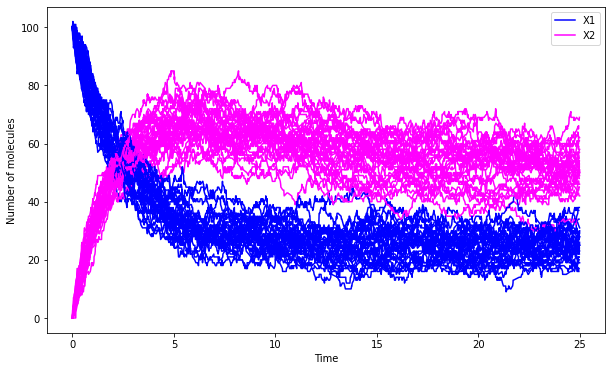

In [31]:
M = np.array([[100, 0]]).T # has shape (2, 1)
c = [10.0, 0.2, 0.4]
max_time = 25
plt.figure(figsize = (10,6))
x1 = []
x2 = []
for i in range(30):
    T, X = gillespie_rna(M, c, max_time)
    plt.plot(T, X[:,0], c='blue'); #X1
    plt.plot(T, X[:,1], c='magenta'); #X2
    x1.append(X[len(X)-1, 0]) #take value at the last timepoint within the current realization
    x2.append(X[len(X)-1, 1])
    plt.xlabel('Time');
    plt.ylabel('Number of molecules')
    plt.legend(('X1', 'X2'));
print('Mean X1 = {}'.format(np.mean(x1)))
print('Mean X2 = {}'.format(np.mean(x2)))
print('Variance X1 = {}'.format(np.var(x1)))
print('Variance X2 = {}'.format(np.var(x2)))
plt.show()

As can be seen, the mean($X_1$) approximately equals to variance($X_1$), and mean($X_2$) approximately equals to variance($X_2$) that is the property of the Poisson distribution.

## 2. Approximate simulation (1.5 p)

Simulate the system by solving the corresponding chemical Langevin equation  using the Euler-Maruyama method. Use `Delta_t = 0.01`. Each solution generates one realization of the diffusion process. Plot one realization with time on the x-axis. You can use the code template below.

In [17]:
def euler_maruyama_rna(M, c, max_time, Delta_t):
    """Euler-Maruyama algorithm for simulating one realization of the diffusion process.

    :param M: Initial state, numpy array with shape (2, 1).
    :param c: Vector of stochastic rate constants, list with length 3.
    :param max_time: Length of simulation time span, one number.
    :param Delta_t: Time step, one number.
    
    :return: 
        T - One-dimensional numpy array containing time points.
        X - Two dimensional numpy array, where the rows contain the system state at each time point.
    """
    num_steps = int(np.ceil(max_time/Delta_t)) # determine number of steps
    T = np.zeros(num_steps)       # store time points in this array
    X = np.zeros((num_steps, 2))  # store the states in this array
    
    # Initialize the system with initial numbers of molecules and initial time
    X[0,:] = M.flatten()
    T[0] = 0.0
    d = len(c)
    S = np.array([[1, 0, -1], [0, -1, 1]]) # stoichiometry matrix
    rates = [0]*d
    # Main loop
    for idx in range(num_steps-1):
        # reaction hazards
        rates[0] = c[0]
        rates[1] = X[idx,1]*c[1]
        rates[2] = X[idx,0]*c[2]
        
        T[idx+1] = T[idx] + Delta_t # update time
        Delta_W = np.random.normal(loc=0, scale=np.sqrt(Delta_t), size=d) # generate normally distributed random numbers 
        x_new = X[idx,:] + Delta_t * (S@rates) + S@np.diag(np.sqrt(rates))@Delta_W # compute new state
        
        # truncate at zero to avoid negative values
        x_new[x_new < 0] = 0.0
        X[idx+1,:] = x_new
    
    return T, X

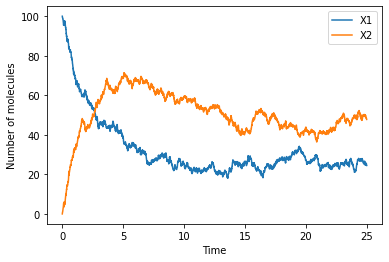

In [24]:
M = np.array([[100, 0]]).T
c = [10.0, 0.2, 0.4]
max_time = 25
Delta_t = 0.01
T, X = euler_maruyama_rna(M, c, max_time, Delta_t)
plot_result(T, X)

## 3. Deterministic simulation (2 p)

If we model the time-dependent *concentrations* $y_i(t) = [X_i](t)$ of each species, using *the law of mass action*, our model can be written as a linear ordinary differential equation

\begin{equation}
\frac{d}{dt} \textbf{y}(t) = A \textbf{y}(t) + \textbf{b},
\end{equation}

where $\textbf{y}(t) = [y_1(t), y_2(t)]^{\top}$. 

**a)** Write the matrix $A$ and vector **b** for our system in terms of the *deterministic* rate constants $k_1, k_2, k_3$.

**b)** Solve the steady state $\textbf{y}(t) = \textbf{y}^*$ of the system, which is defined as the solution to $\frac{d}{dt} \textbf{y}(t) = 0$. Give your answer in terms of the deterministic rate constants.

**c)**  Assume that the system is in a volume of $V = N_A^{-1}$, where $N_A$ is the Avogadro number. Then the deterministic rate constants have the same values as the stochastic ones (don't think about units here). What is the steady state you get when you plug in the values of $k_1, k_2, k_3$ in the formula you obtained in **b)**.

**d)** The linear differential equation has the analytic solution

\begin{equation}
\textbf{y}(t) = \textbf{y}^* + e^{At} (\textbf{y}(0) - \textbf{y}^*)
\end{equation}

where $e^{At}$ is a matrix exponential (see [scipy.linalg.expm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html)). Using $\textbf{y}(0) = \textbf{m}$, evaluate and plot the solution $\textbf{y}(t)$ at 101 equally spaced time points on the interval $t \in [0, 25]$. Plot $y_1$ and $y_2$ in the same figure (using different colours) with time on the x-axis.

**e)** Compare your simulations in Problems 1, 2 and 3. Do you think that the system has reached its steady state at $t=25$?

### a) Write the matrix  𝐴  and vector b for our system

$$ \begin{cases} \frac{d[X_1](t)}{dt} & = & k_1 - k_3 [X_1](t) \\ \frac{d[X_2](t)}{dt} & = & k_3[X_1](t) - k_2 [X_2](t) \end{cases} \Rightarrow \frac{d}{dt} \begin{pmatrix}
                [X_1](t) \\
                [X_2](t)
                \end{pmatrix} = \begin{pmatrix}
                                    -k_3 & 0 \\
                                    k_3 & -k_2
                                    \end{pmatrix} \cdot \begin{pmatrix}
                                                            [X_1](t) \\
                                                            [X_2](t)
                                                            \end{pmatrix} + \begin{pmatrix}
                                                                                k_1 \\
                                                                                0
                                                                                \end{pmatrix} $$
                                                                                
 $$ A = \begin{pmatrix}
    -k_3 & 0 \\
    k_3 & -k_2
    \end{pmatrix} $$
    
$$ b = \begin{pmatrix}
    k_1 \\
    0
    \end{pmatrix} $$                                                           

### b) Solve the steady state of our system.

$$ \begin{cases} 0 & = & k_1 - k_3 [X_1] \\ 0 & = & k_3[X_1] - k_2 [X_2] \end{cases} \Rightarrow \begin{cases} [X_1]^* & = & \frac{k_1}{k_3} \\ [X_2]^* & = & \frac{k_1}{k_2} \end{cases}  $$

### c) What is the steady state you get when you plug in the values  in the formula you obtained in b)

$$ \begin{cases} [X_1] & = & \frac{c_1}{c_3} \\ [X_2] & = & \frac{c_1}{c_2} \end{cases} \Rightarrow \begin{cases} [X_1] & = & \frac{10}{0.4} \\ [X_2] & = & \frac{10}{0.2} \end{cases} \Rightarrow \begin{cases} [X_1] & = & 25 \\ [X_2] & = & 50 \end{cases}  $$

### d) Evaluate and plot the analytic solution  𝐲(𝑡)  at 101 equally spaced time points on the interval  𝑡

In [7]:
def find_steady(A, b):
    return -np.linalg.inv(A)@b 

A = np.array([[-0.4, 0.0], [0.4, -0.2]])
b = np.array([10.0, 0.0])
find_steady(A,b)

array([25., 50.])

[array([100.,   0.]), array([92.86280635,  9.39732974]), array([86.40480648, 17.67412884]), array([80.56136655, 24.94806454]), array([75.27400345, 31.3250684 ]), array([70.48979948, 36.90047935]), array([66.16087271, 41.76007665]), array([62.24389778, 45.9810134 ]), array([58.69967231, 49.63265999]), array([55.49272448, 52.7773662 ]), array([52.59095809, 55.4711498 ]), array([49.96533128, 57.76431848]), array([47.58956589, 59.70203182]), array([45.43988448, 61.32480872]), array([43.4947723 , 62.66898579]), array([41.73476201, 63.76713125]), array([40.14223885, 64.64841871]), array([38.7012643 , 65.33896459]), array([37.39741662, 65.86213274]), array([36.21764644, 66.23880946]), array([35.15014624, 66.48765163]), array([34.18423212, 66.62531067]), array([33.31023688, 66.66663462]), array([32.51941328, 66.62485038]), array([31.8038465, 66.5117282]), array([31.1563749 , 66.33772989]), array([30.57051837, 66.11214257]), array([30.04041346, 65.84319915]), array([29.5607547, 65.538187 ]), ar

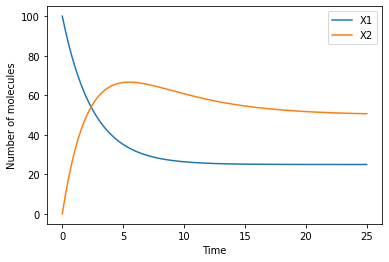

In [4]:
timepoints = np.linspace(0, 25, num=101)
y_steady = np.array([[25, 50]]).T.flatten()
M = np.array([[100, 0]]).T.flatten()
A = np.array([[-0.4, 0.0], [0.4, -0.2]])
y = []
for t in timepoints:
    y.append((y_steady + expm(A*t)@(M - y_steady)))
print(y)
plot_result(timepoints, y)

### e) Compare your simulations in Problems 1, 2 and 3. Do you think that the system has reached its steady state at  𝑡=25 ? 

Not really, because the concentrations of $X_1$ and $X_2$ continue to decrease a bit, but they are already very close to the steady solution $y(t) = [25,50]^T$.

As can be seen from resulted graphs, stochastic simulations with Gillespie and Euler-Maruyama algorithms represent the correct trend of the process and correspond to its analytical solution.